In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Load preprocessed data
prepared in previous notebook

In [2]:
data_dir = pathlib.Path("../data")
processed_file = data_dir / "transcoding_processed.csv"
try:
    df = pd.read_csv(processed_file)
    print("Data loaded succesfully")

except FileNotFoundError:
    print(f"Error: Failed to locate file: {processed_file.absolute()}")

Data loaded succesfully


In [3]:
df.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,umem,utime,codec_flv,codec_h264,codec_mpeg4,codec_vp8,o_codec_flv,o_codec_h264,o_codec_mpeg4,o_codec_vp8
0,130.35667,176.0,144.0,54590.0,12.0,27.0,1537.0,0.0,1564.0,64483.0,...,22508.0,0.612,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,130.35667,176.0,144.0,54590.0,12.0,27.0,1537.0,0.0,1564.0,64483.0,...,25164.0,0.980,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,130.35667,176.0,144.0,54590.0,12.0,27.0,1537.0,0.0,1564.0,64483.0,...,29228.0,1.216,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,130.35667,176.0,144.0,54590.0,12.0,27.0,1537.0,0.0,1564.0,64483.0,...,34316.0,1.692,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,130.35667,176.0,144.0,54590.0,12.0,27.0,1537.0,0.0,1564.0,64483.0,...,58528.0,3.456,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Train-Test split

In [4]:
X = df.drop(columns=['utime'])
y = df['utime']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature scaling (standarization)
using `StandardScaler` - scaler is fited __only__ on training set to prevent data leakage

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [7]:
X_train_scaled.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,o_height,umem,codec_flv,codec_h264,codec_mpeg4,codec_vp8,o_codec_flv,o_codec_h264,o_codec_mpeg4,o_codec_vp8
0,0.409620,1.411549,1.275497,0.836439,0.247626,-0.253945,0.558370,-0.104592,0.546535,0.526418,...,-1.140545,-0.072936,-0.332771,-0.921493,-0.460458,1.660462,-0.575958,1.738348,-0.580687,-0.577497
1,0.526868,1.411549,1.275497,0.337322,0.797185,1.580089,1.025753,-0.104592,1.032894,1.983534,...,0.682714,-0.090183,-0.332771,1.085195,-0.460458,-0.602242,1.736237,-0.575259,-0.580687,-0.577497
2,-0.924298,1.411549,1.275497,1.883041,0.797185,-0.985080,-0.917416,-0.104592,-0.920900,-0.216533,...,0.682714,-0.090183,-0.332771,1.085195,-0.460458,-0.602242,-0.575958,-0.575259,1.722099,-0.577497
3,0.006033,-0.313264,-0.218646,-0.170282,-0.032933,0.687856,0.036987,-0.104592,0.044293,-0.126282,...,-1.140545,-0.117492,-0.332771,1.085195,-0.460458,-0.602242,-0.575958,-0.575259,1.722099,-0.577497
4,-0.474437,-0.313264,-0.218646,-0.262630,0.797185,-0.167200,-0.315116,-0.104592,-0.315000,-0.245305,...,1.822251,4.431603,-0.332771,1.085195,-0.460458,-0.602242,-0.575958,1.738348,-0.580687,-0.577497


In [8]:
X_train_scaled.describe()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,o_height,umem,codec_flv,codec_h264,codec_mpeg4,codec_vp8,o_codec_flv,o_codec_h264,o_codec_mpeg4,o_codec_vp8
count,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,...,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04,5.502700e+04
mean,4.157864e-17,-8.251164e-17,-5.423300e-18,5.642815e-17,1.107903e-16,2.582524e-17,-9.090484e-17,2.479223e-17,-5.784854e-17,-2.375922e-17,...,-9.297086e-17,-1.306757e-16,-7.950946e-17,9.845873e-17,-1.038175e-16,-2.763301e-17,8.005824e-18,4.648543e-17,2.492136e-17,-4.338640e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-9.463735e-01,-9.686930e-01,-1.115132e+00,-6.261101e-01,-2.425644e+00,-1.158570e+00,-1.071969e+00,-1.045922e-01,-1.074215e+00,-6.585141e-01,...,-1.140545e+00,-2.112382e+00,-3.327710e-01,-9.214932e-01,-4.604582e-01,-6.022419e-01,-5.759583e-01,-5.752588e-01,-5.806868e-01,-5.774972e-01
25%,-6.683812e-01,-6.582267e-01,-7.166936e-01,-5.112355e-01,-1.139757e+00,-7.620221e-01,-7.181727e-01,-1.045922e-01,-7.187664e-01,-5.691464e-01,...,-8.366682e-01,-1.174922e-01,-3.327710e-01,-9.214932e-01,-4.604582e-01,-6.022419e-01,-5.759583e-01,-5.752588e-01,-5.806868e-01,-5.774972e-01
50%,-2.153507e-01,-3.132641e-01,-2.186460e-01,-3.682091e-01,2.467808e-01,-2.539450e-01,-1.680117e-01,-1.045922e-01,-1.653642e-01,-4.398122e-01,...,-7.697695e-02,-9.018349e-02,-3.327710e-01,-9.214932e-01,-4.604582e-01,-6.022419e-01,-5.759583e-01,-5.752588e-01,-5.806868e-01,-5.774972e-01
75%,3.496278e-01,3.169841e-02,2.794016e-01,-3.820839e-02,7.971849e-01,4.647982e-01,4.481687e-01,-1.045922e-01,4.371922e-01,1.329445e-01,...,6.827143e-01,-8.837660e-02,-3.327710e-01,1.085195e+00,-4.604582e-01,1.660462e+00,-5.759583e-01,-5.752588e-01,1.722099e+00,1.731610e+00
max,1.244269e+01,2.791399e+00,2.769640e+00,5.031510e+00,2.180715e+00,1.666130e+01,1.241561e+01,7.833229e+01,1.248564e+01,1.817963e+01,...,1.822251e+00,4.964431e+00,3.005069e+00,1.085195e+00,2.171750e+00,1.660462e+00,1.736237e+00,1.738348e+00,1.722099e+00,1.731610e+00


### Baseline model - Linear Regression
simple model to establish performance baseline

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"R^2 Score: {r2_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

R^2 Score: 0.6494
MAE: 5.7112


### Advanced model - Random Forest Regressor
training ensemble model (100 trees) to capture non-linear relationships

In [10]:
# 100 decision trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training of Random Forest Regressor (might take a while)")
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
end_time = time.time()

y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"R^2 Score: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

print(f"Training time: {end_time - start_time:.2f} s")

print(f"R^2 improvement: {r2_rf - r2_lr:.4f}")
print(f"MAE improvement: {mae_rf - mae_lr:.4f}")

Training of Random Forest Regressor (might take a while)
R^2 Score: 0.9898
MAE: 0.5162
Training time: 1.82 s
R^2 improvement: 0.3403
MAE improvement: -5.1950


### Model comparison

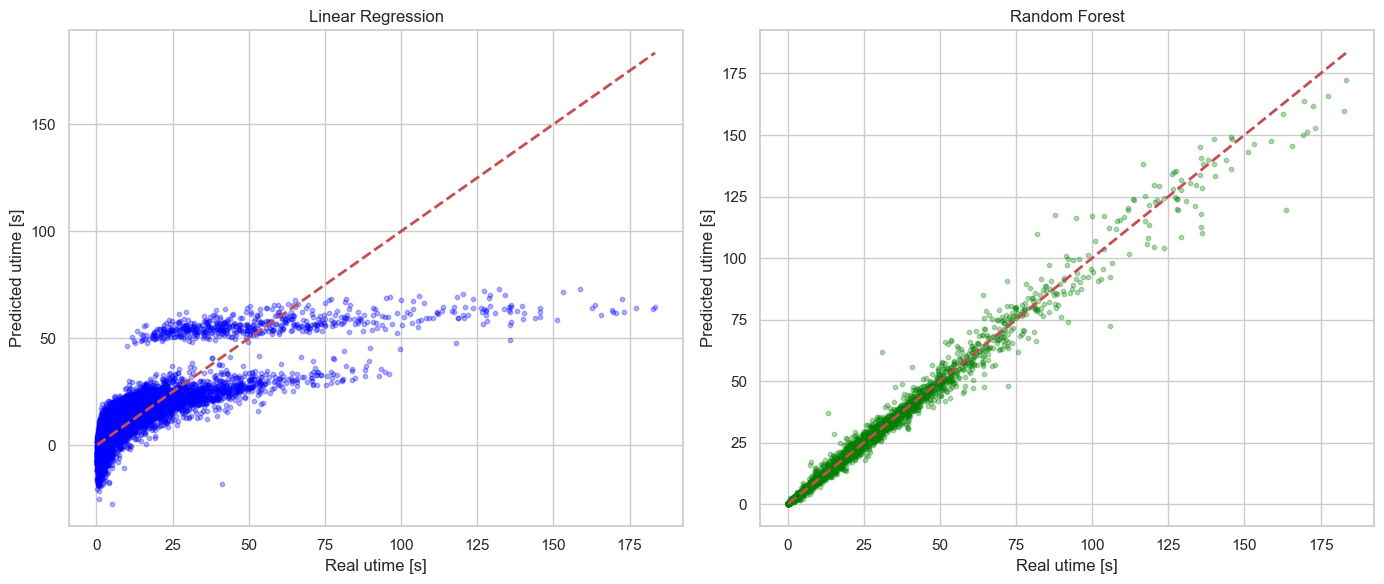

In [11]:
plt.figure(figsize=(14, 6))


# LR
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='blue', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Linear Regression')
plt.xlabel('Real utime [s]')
plt.ylabel('Predicted utime [s]')

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Random Forest')
plt.xlabel('Real utime [s]')
plt.ylabel('Predicted utime [s]')

plt.tight_layout()
plt.show()

### Cross-validation
validating the stability of Random Forest model

In [12]:
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"R^2 scored after 5 iterations: {cv_scores}")
print(f"Mean R^2: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

R^2 scored after 5 iterations: [0.98616408 0.98868526 0.98542833 0.98882246 0.98672547]
Mean R^2: 0.9872
Standard deviation: 0.0014


### Hyperparameter analysis
how does the numer of trees impact RMSE error?

In [13]:
n_trees_list = [1, 5, 10, 20, 50, 100]
rmse_scores = []

for n in n_trees_list:
    model_temp = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    model_temp.fit(X_train_scaled, y_train)

    preds = model_temp.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse_scores.append(rmse)
    print(f"n_estimators={n} => RMSE: {rmse:.4f}")

n_estimators=1 => RMSE: 2.9114
n_estimators=5 => RMSE: 1.8129
n_estimators=10 => RMSE: 1.6621
n_estimators=20 => RMSE: 1.6596
n_estimators=50 => RMSE: 1.6313
n_estimators=100 => RMSE: 1.6174


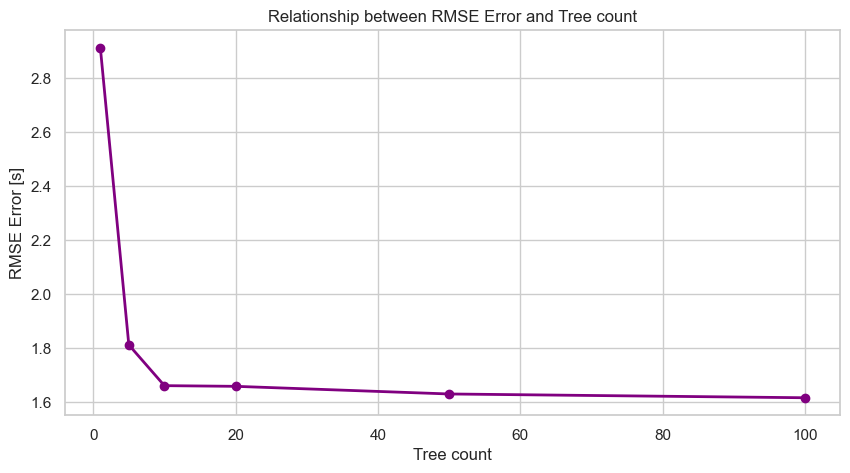

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, rmse_scores, marker='o', linestyle='-', color='purple', linewidth=2)
plt.title('Relationship between RMSE Error and Tree count')
plt.xlabel('Tree count')
plt.ylabel('RMSE Error [s]')
plt.grid(True)
plt.show()

### Feature imporance
which features contribute the most to model's predictions

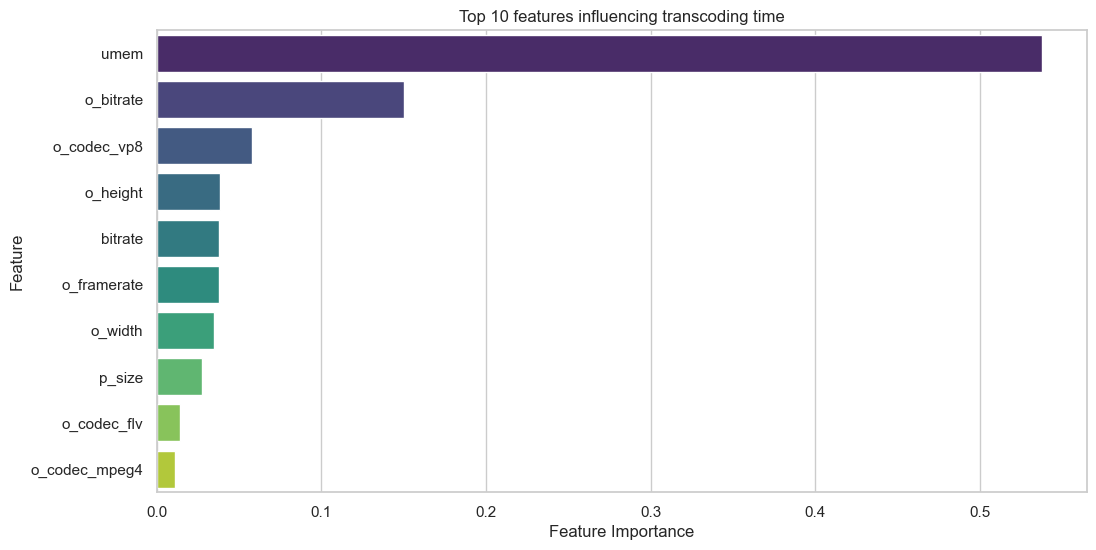

In [15]:
importances = rf_model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10) # top 10

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis', hue='Feature', legend=False)
plt.title('Top 10 features influencing transcoding time')
plt.xlabel('Feature Importance')
plt.show()

### Residual analysis
checking distribution of errors

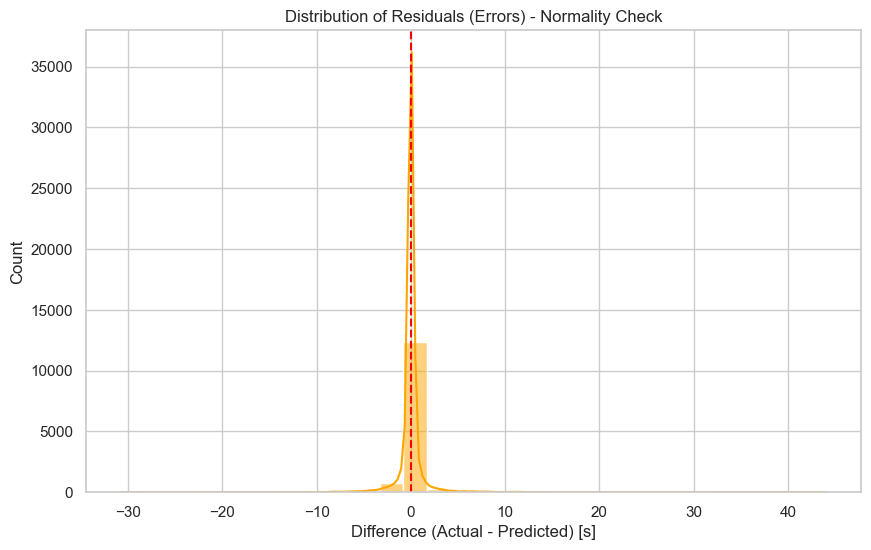

Mean residual value: -0.0052


In [16]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')

plt.title('Distribution of Residuals (Errors) - Normality Check')
plt.xlabel('Difference (Actual - Predicted) [s]')
plt.ylabel('Count')

plt.axvline(x=0, color='red', linestyle='--')
plt.show()

print(f"Mean residual value: {residuals.mean():.4f}")